# Capstone Project

## Steps in this Analysis

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Train target model
- Evaluate target model
- Using model on unseen data
- Repredicting on unseen photos
- Finetuning the Model with Own Photos (using data augmentation)

## Let's begin!


## Before starting

We want to make sure we have access to a GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jul 25 10:55:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   45C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install autodistill

**NOTE:** Autodistill is an ecosystem designed to use large, slower foundation models to train smaller, faster supervised models. Each Base model and Target model has its own separate repository and pip package.

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 93.3 MB/s eta 0:00:00


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images, annotated or not, and use for target model training.

## Download Images

We will download images from prelabeled images in Roboflow of refridgerator and ingredients. We had originally picked a dataset with less photos, but after finding this one, it has more photos and more labels- 168 to be exact.

### Download Images from Roboflow

You can download datasets from Roboflow using the below lines of code. You can download datasets associated with your account, or any of the 200,000+ public datasets on [Roboflow Universe](https://universe.roboflow.com/). To download a dataset from Roboflow, you will need a [free Roboflow account](https://app.roboflow.com).

To find a model URL, go to a dataset page on Roboflow, then click "Model" in the sidebar to view the latest model version. Copy the page URL, then paste it into the `download_dataset()` function below.

In [4]:
import os
import zipfile
import requests

# Replace with your Roboflow dataset URL
dataset_url = "https://universe.roboflow.com/ds/zIHdrdMZsh?key=MMnQ7LDBN4"

# Directory to save the dataset
dataset = "/content/datasets/roboflow_dataset"

# Create the directory if it doesn't exist
os.makedirs(dataset, exist_ok=True)

# Download the dataset
response = requests.get(dataset_url)
dataset_path = os.path.join(dataset, "dataset.zip")

# Save the downloaded file to the dataset directory
with open(dataset_path, "wb") as file:
    file.write(response.content)

# Extract the dataset
with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall(dataset)

### Display image sample

**NOTE:** Before we start building a model, let's make sure we have everything we need.

In [5]:
import supervision as sv
IMAGE_DIR_PATH = '/content/datasets/roboflow_dataset/train/images'
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 14130


**NOTE:** We can also plot sample of our image dataset.

In [6]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

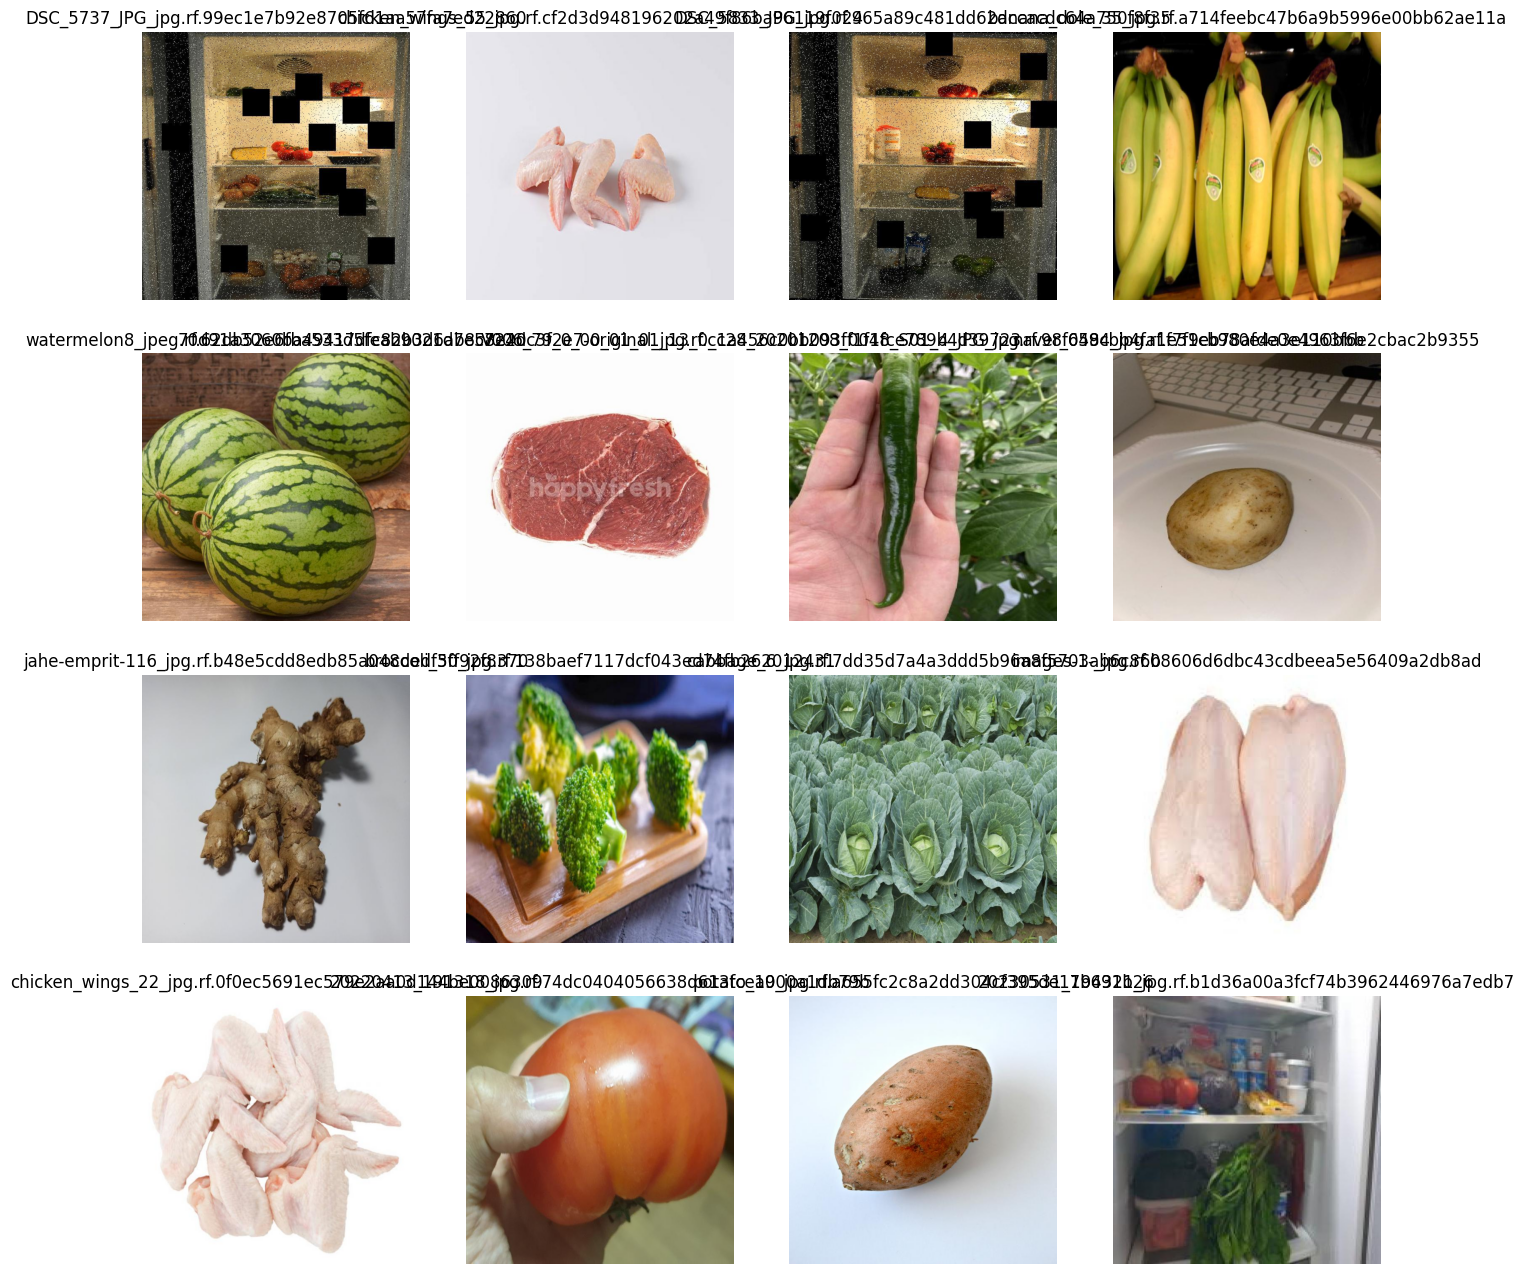

In [7]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

We can see that the images here are not high resolution, and some of them have added noise. This is a common technique to add variety or more data to the training set, allowing for more extensive training.

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [8]:
ANNOTATIONS_DIRECTORY_PATH = '/content/datasets/roboflow_dataset/train/labels'
IMAGES_DIRECTORY_PATH = "/content/datasets/roboflow_dataset/train/images"
DATA_YAML_PATH = "/content/datasets/roboflow_dataset/data.yaml"

Here, we can see all of the labeled food items that the model is able to predict with pretty high accuracy. It has a pretty good variety of 76 labels.

In [9]:
# print data.yaml
!cat DATA_YAML_PATH= '/content/datasets/roboflow_dataset/data.yaml'

cat: 'DATA_YAML_PATH=': No such file or directory
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 163
names: ['-', '10_pineapple', '10_tangerine', 'Apple', 'Bagel', 'Banana', 'Bitter melon', 'Cucumber', 'Garlic', 'Green Chili', 'Lady finger', 'Mushroom', 'Onion', 'Orange', 'Potato', 'Sponge Gourd', 'Tomato', 'ampalaya', 'apple', 'asparagus', 'avocado', 'bacon', 'banana', 'beef', 'bell pepper', 'bell_pepper', 'bento', 'bitter gourd', 'blueberries', 'bok choy', 'bottle', 'bread', 'broccoli', 'butter', 'cabbage', 'can', 'canned_tuna', 'carrot', 'cashew', 'cauliflower', 'cheese', 'cherry', 'chicken breast', 'chicken thigh', 'chicken wing', 'chicken', 'chicken_breast', 'chilli', 'chocolate', 'corn', 'crab', 'cream-cheese', 'cucumber', 'dates', 'egg', 'egg_', 'eggplant', 'eggs', 'fish', 'fish_cake', 'flour', 'french_fries', 'garlic', 'ginger', 'goat_cheese', 'grapefruit', 'grapes', 'grated_cheese', 'green chilli', 'green-chillies', 'green_beans', 'green_onion', 'ground_

## Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR. For the sake of this analysis, we use the YOLOv8 model.

In [12]:
from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=5)

New https://pypi.org/project/ultralytics/8.2.64 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/roboflow_dataset/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

## Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory. If you have run this on Colab, it will be found in your folder.

/content


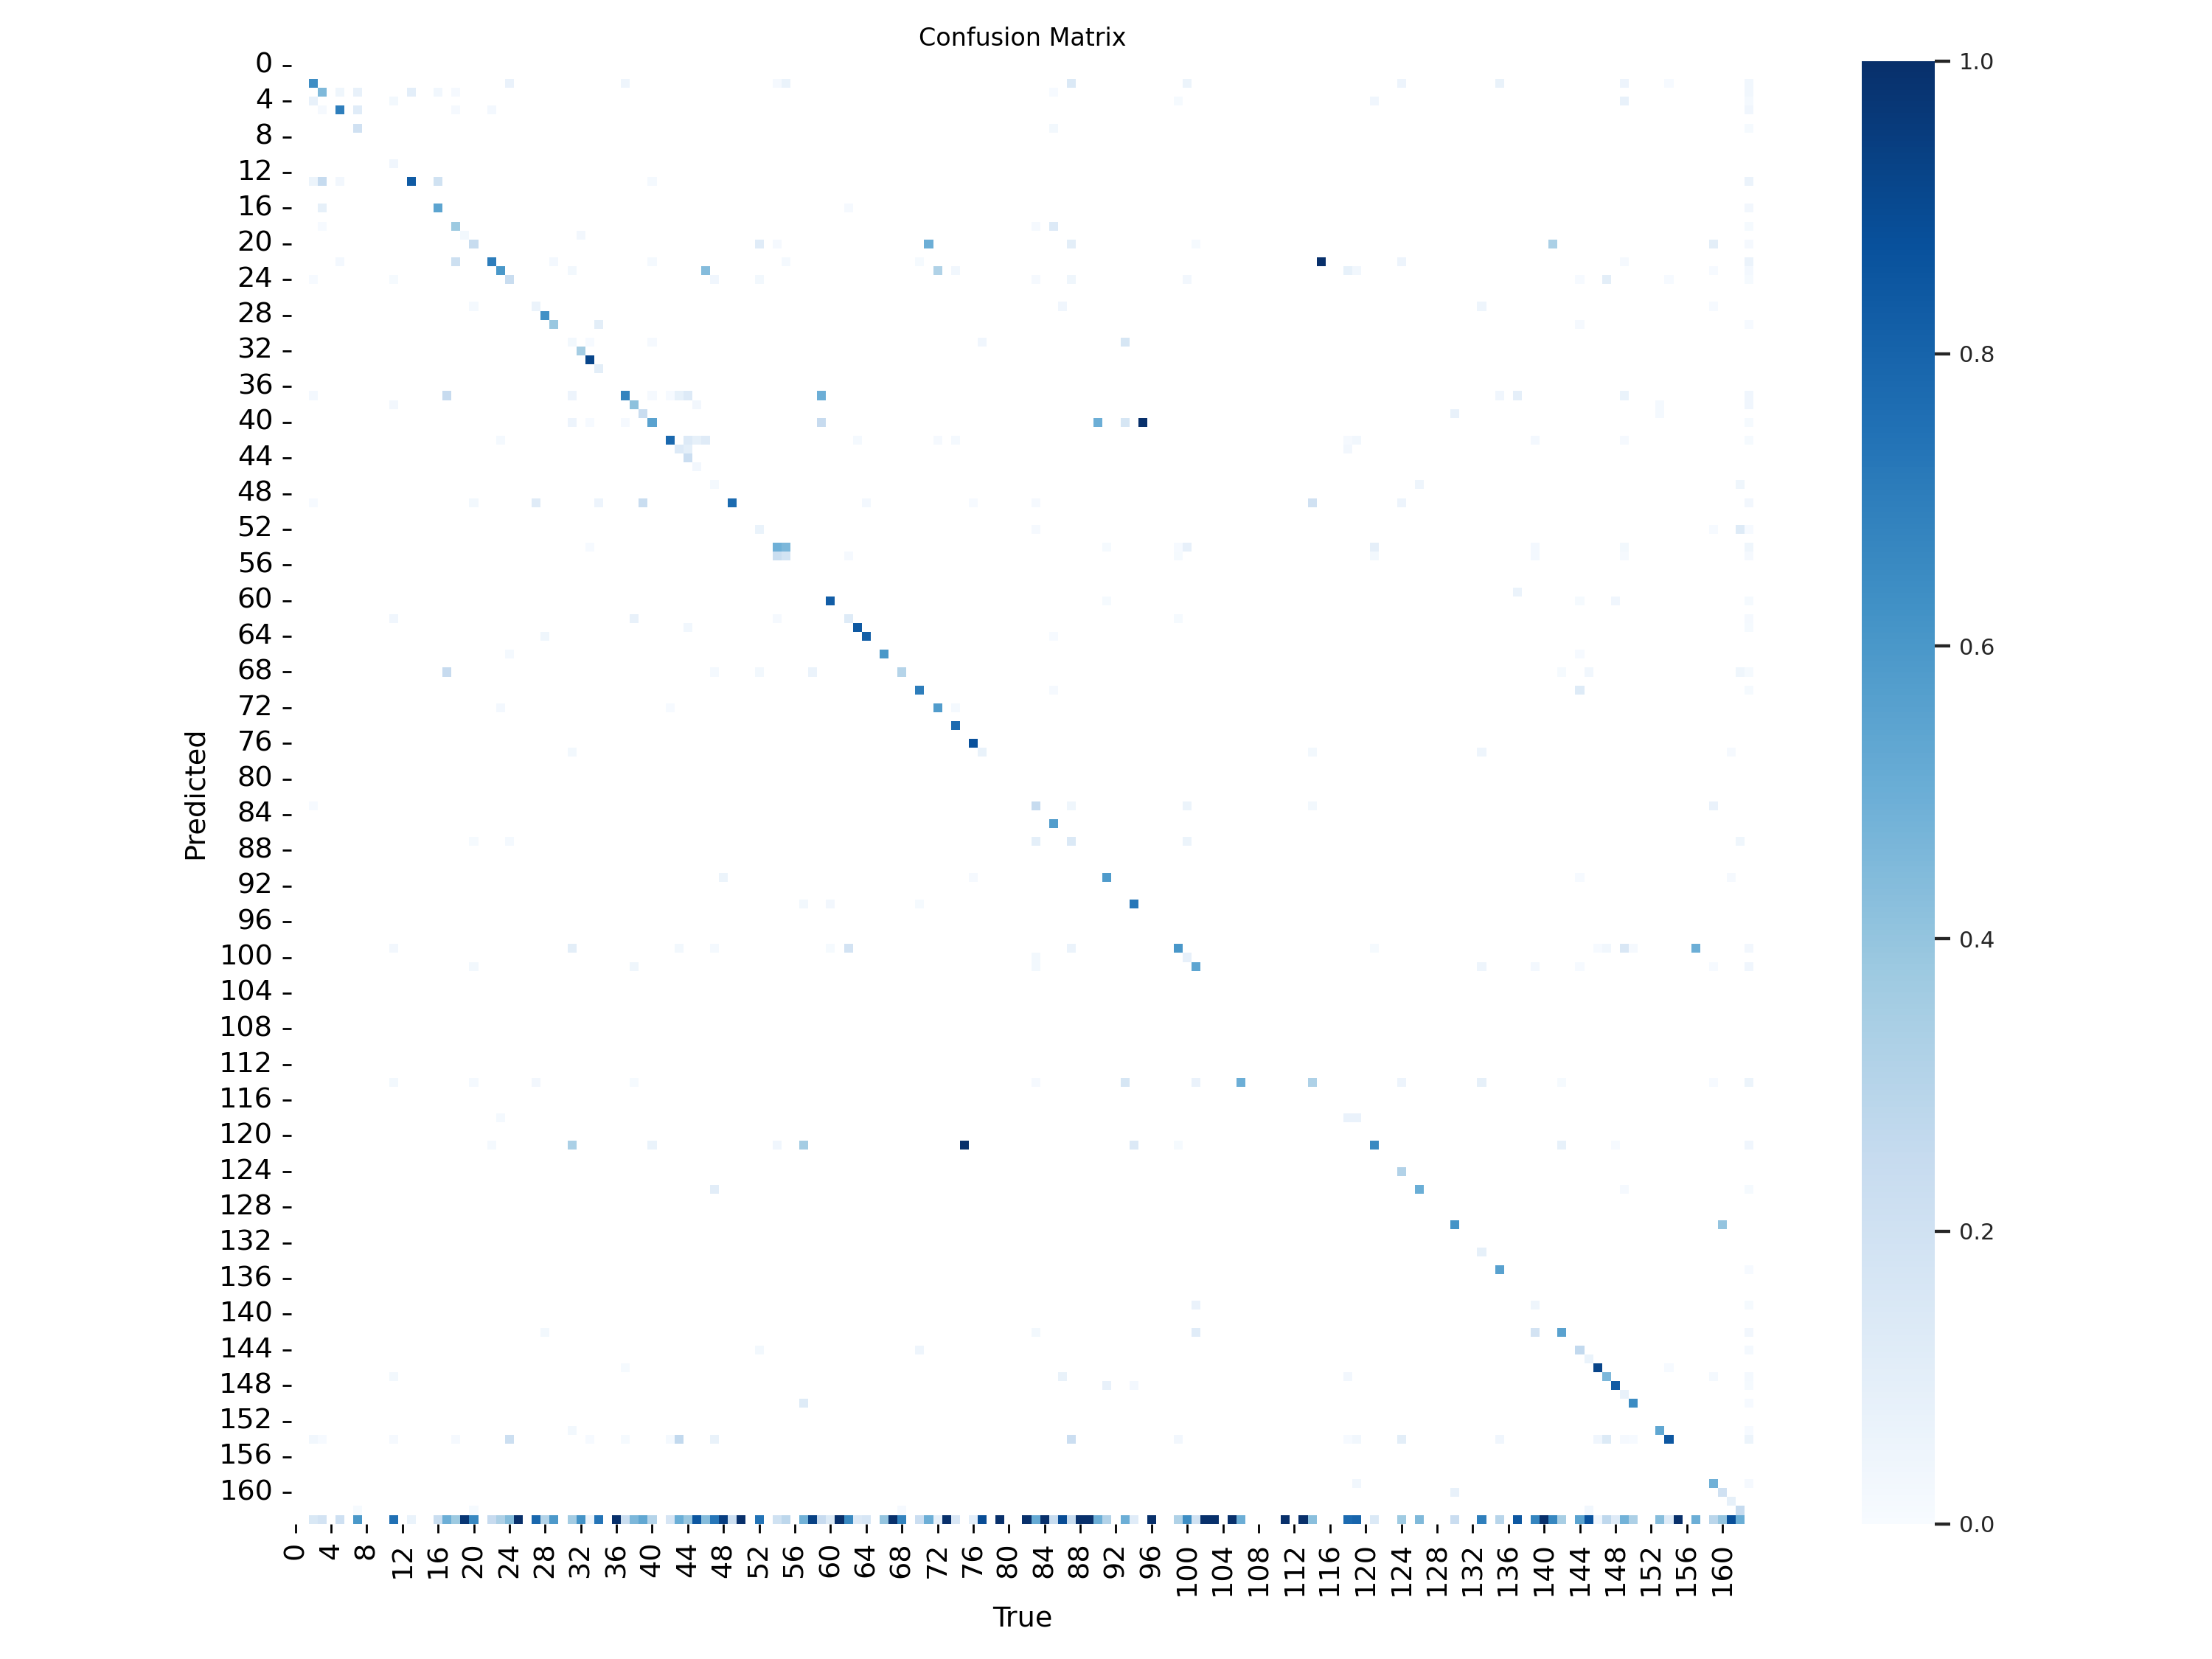

In [20]:
%cd {HOME}

from IPython.display import Image

Image('/content/runs/detect/train2/confusion_matrix.png', width=600)

This confusion matrix shows that the model is pretty decent at recognizing and labels the items for themselves from this dataset specifically, performing well on the validation set.

/content


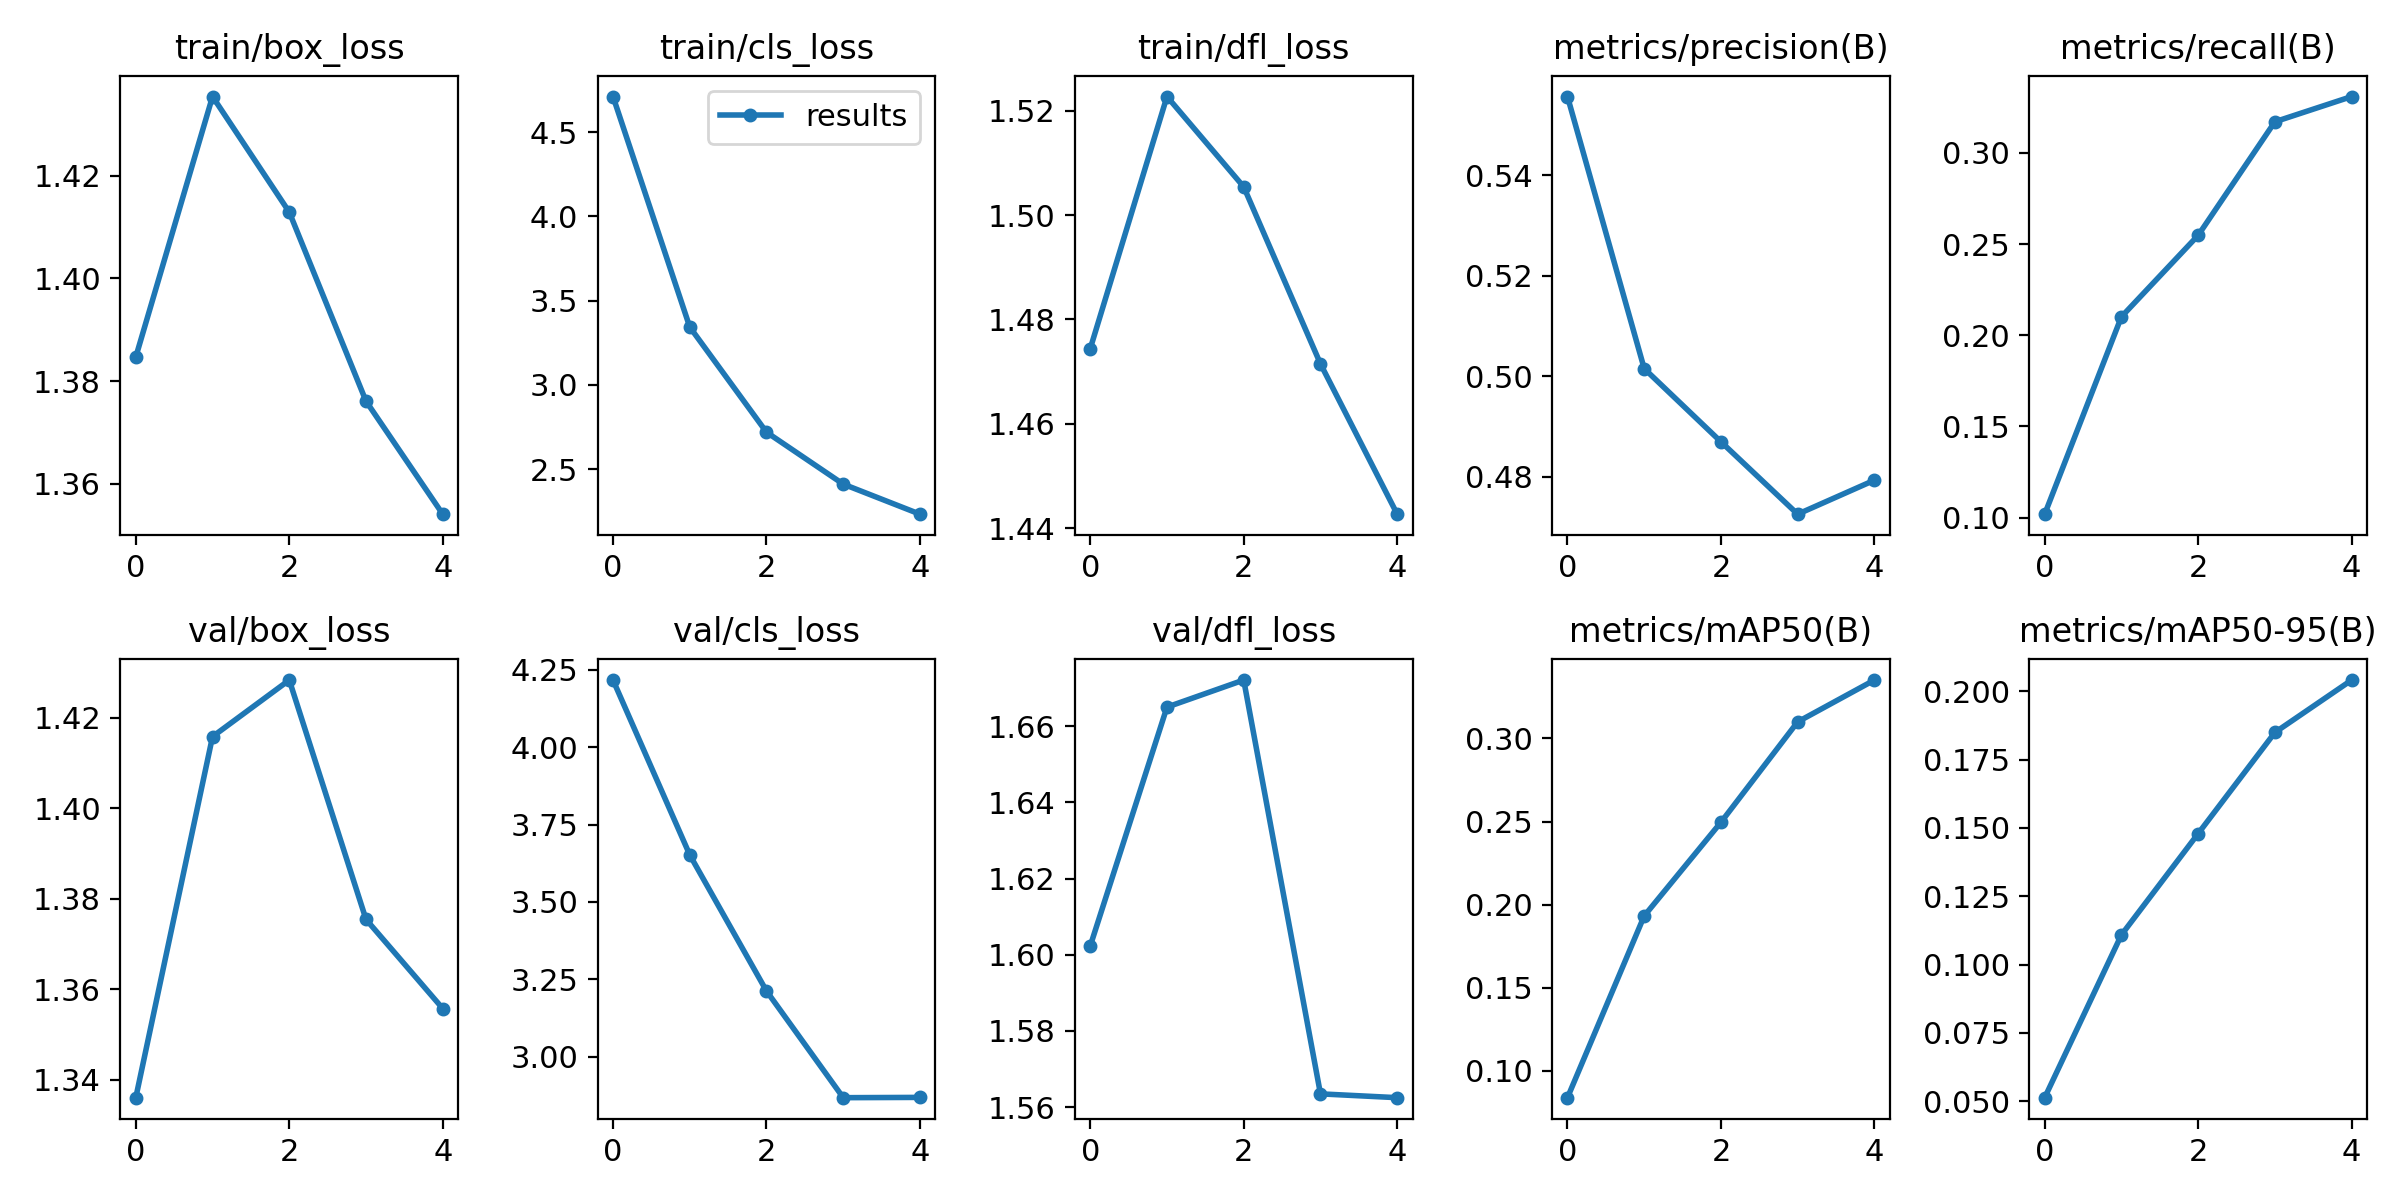

In [21]:
%cd {HOME}

from IPython.display import Image

Image('/content/runs/detect/train2/results.png', width=600)

Below, we can see a batch of validation images and the predictions from the model.

/content


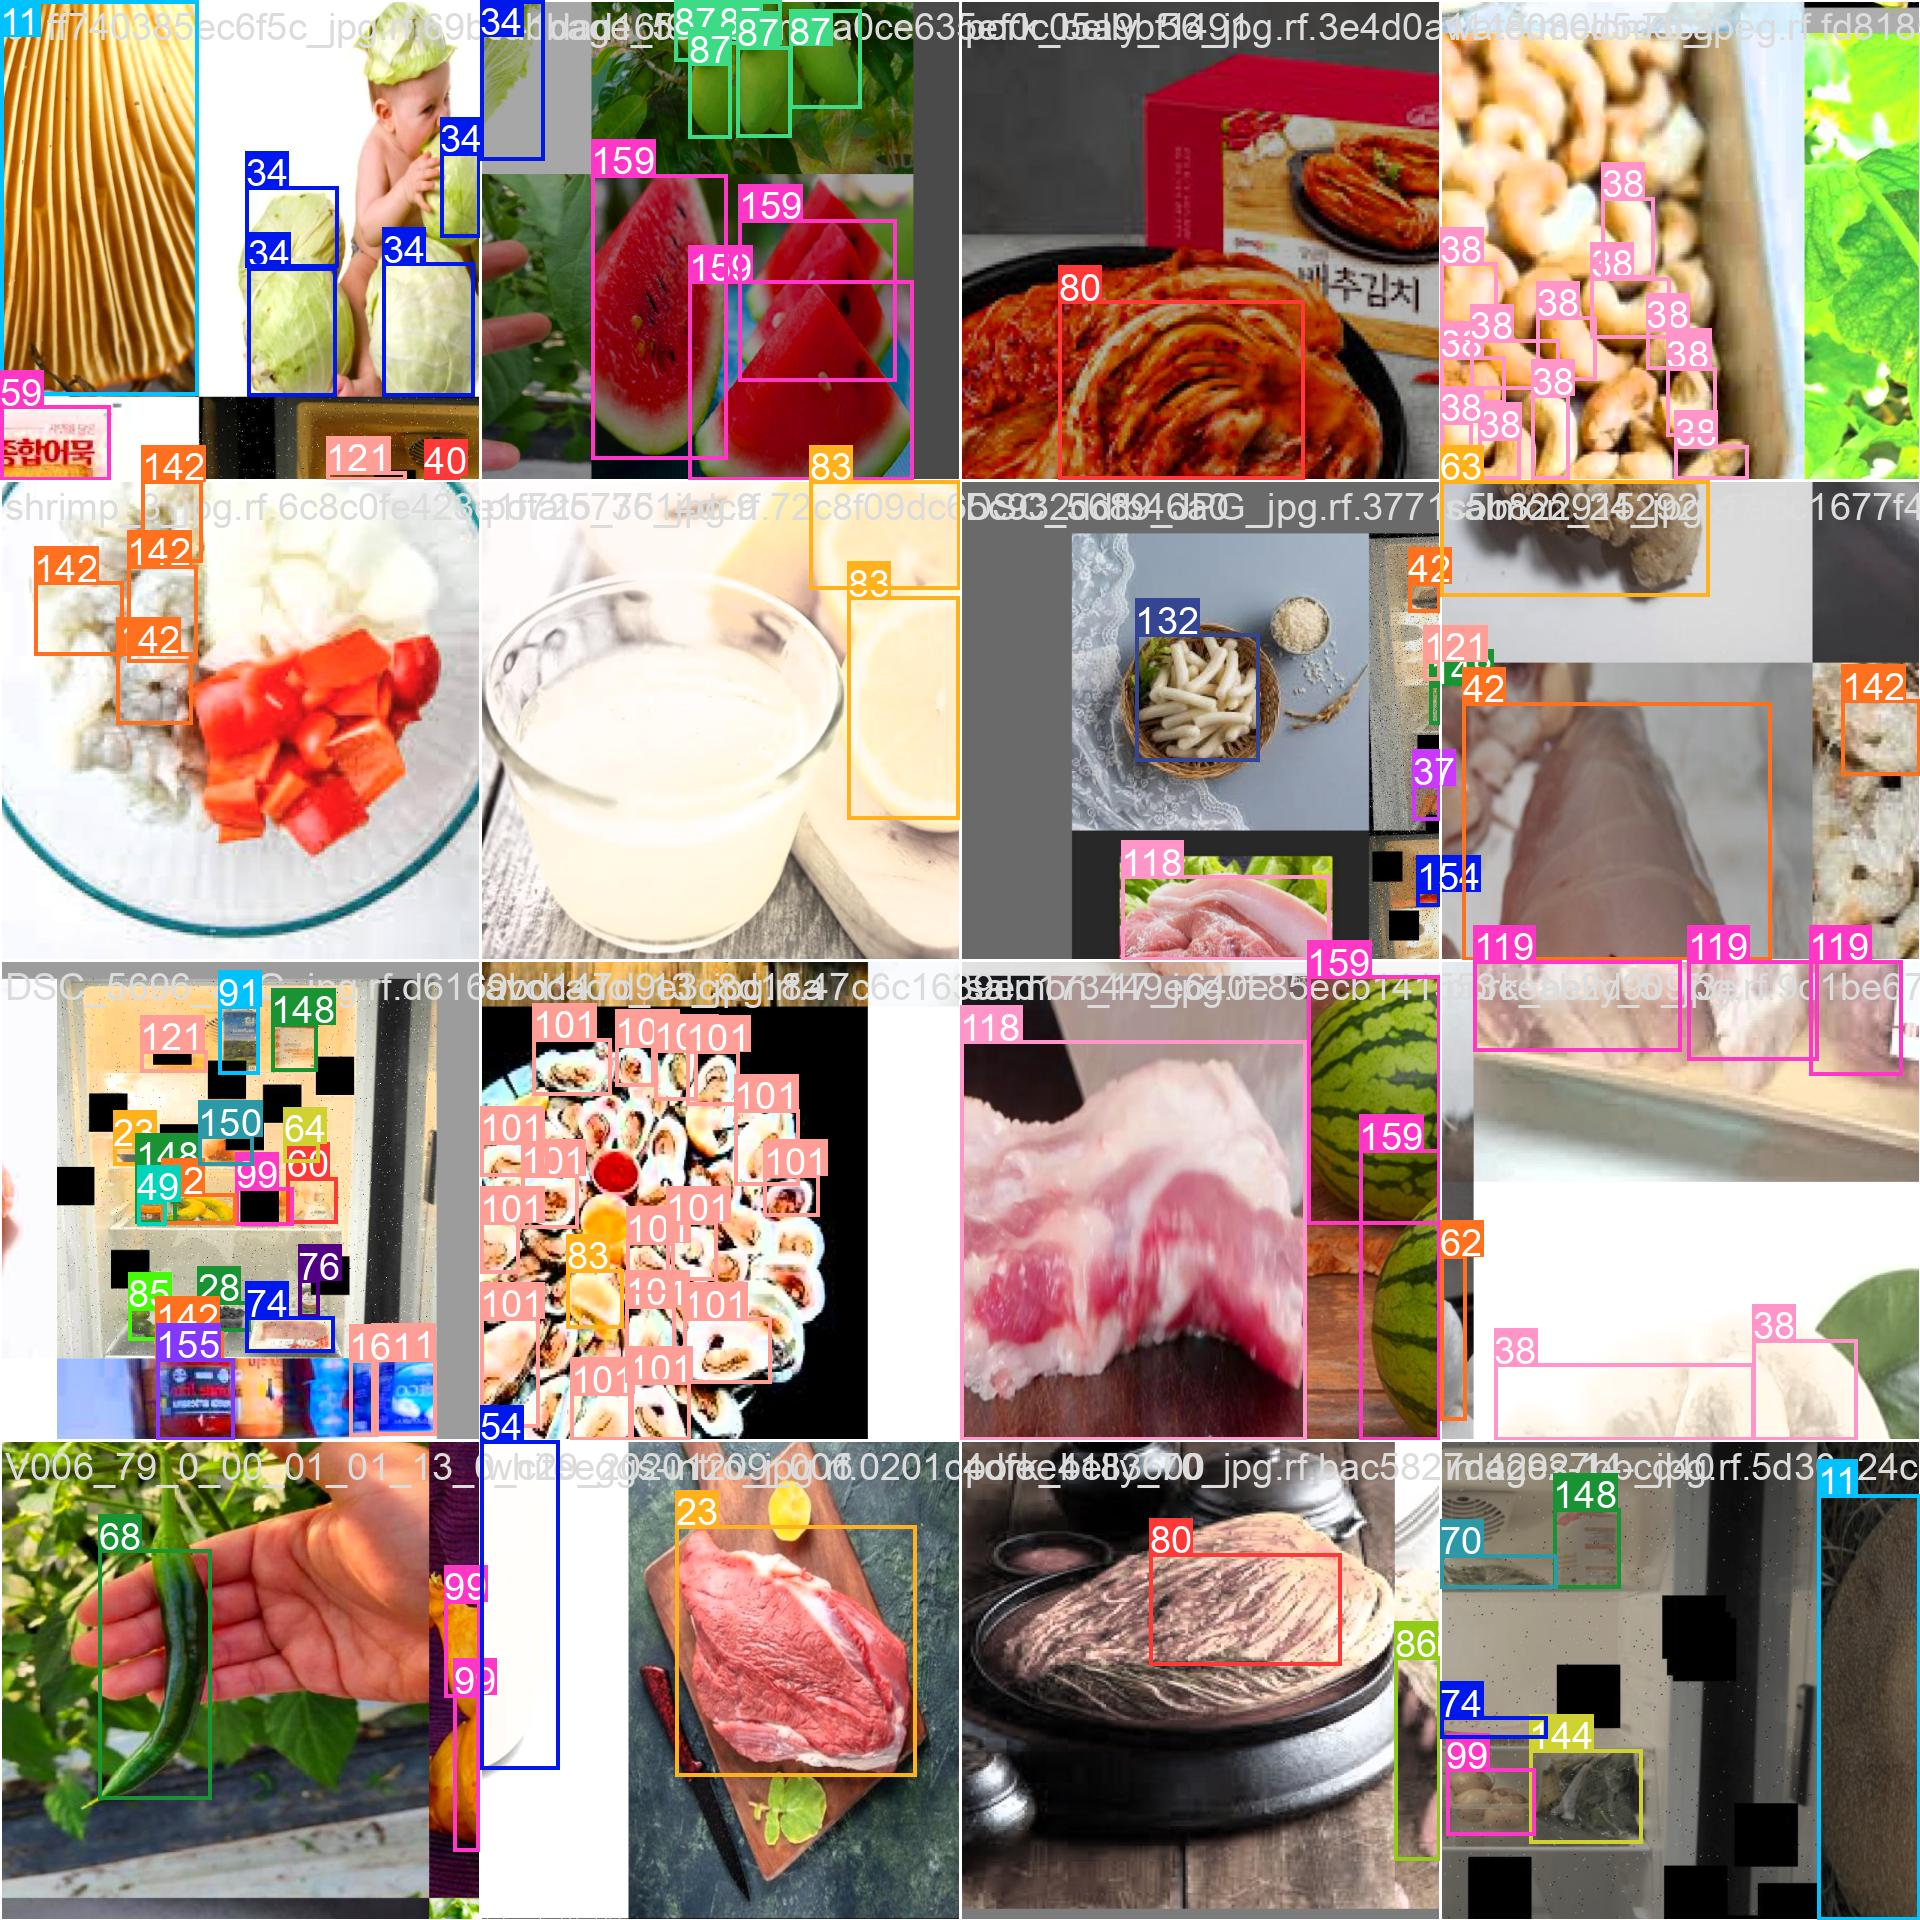

In [16]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/train_batch0.jpg', width=600)

In [23]:
# This can be used to save the data in Google Drive - lack of space though
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Testing the model on unseen images

We can test the model using the function predict_new and by putting the best.pt file into the directory. If you choose to not run the whole notebook, then you can upload it locally to your Colab and change the model file path to be as below.

In [26]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the best model using the ultralytics YOLO class
model = YOLO('/content/runs/detect/train2/weights/best.pt')

def predict_new(imagepath):
  # Load the image
  image = cv2.imread(imagepath)

  # Preprocess the image
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Make a prediction
  results = model.predict(image_rgb)

  # Postprocess the predictions and display the results
  for result in results:
      for box in result.boxes:
          x1, y1, x2, y2 = box.xyxy[0].tolist()  # Convert the tensor to a list of values
          confidence = box.conf.item()  # Extract the confidence value
          class_id = int(box.cls.item())  # Extract the class label value
          label = model.names[class_id]  # Get the class name from the model's class names
          cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
          cv2.putText(image_rgb, f'{label} {confidence:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

  # Show the image with the predictions
  plt.imshow(image_rgb)
  plt.axis('off')
  plt.show()

# Fine Tuning the Model with Own Photos

In [32]:
!ls

datasets  drive  my_photos_annotated.zip  runs	sample_data  yolov8n.pt


In [38]:
from ultralytics import YOLO
import zipfile
import yaml

# Step 1: Extract the zip file to a directory in Colab
zip_path = '/content/my_photos_annotated.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Load your pretrained model
pretrained_model_path = '/content/runs/detect/train2/weights/best.pt'
training_model = YOLO(pretrained_model_path)

# Path to images and labels directories inside 'annotated_images' extracted folder
images_dir = '/content/my_photos_annotated/images'
labels_dir = '/content/my_photos_annotated/labels'

## Read in your dataset configuration YAML
dataset_config_file = '/content/datasets/roboflow_dataset/data.yaml'

# Step 4: Configure training parameters and perform transfer learning
training_model.train(
    data=dataset_config_file,
    epochs=5,
    batch=13,
    name='fine_tuned_model',
    lr0=0.001,
    exist_ok=True,
)

New https://pypi.org/project/ultralytics/8.2.65 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=/content/runs/detect/train2/weights/best.pt, data=/content/datasets/roboflow_dataset/data.yaml, epochs=5, patience=50, batch=13, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=fine_tuned_model, exist_ok=True, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agno

In [40]:
def predict_new_finetuned(imagepath):
  # Load the image
  image = cv2.imread(imagepath)

  # Preprocess the image
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Make a prediction
  results = training_model.predict(image_rgb)

  # Postprocess the predictions and display the results
  for result in results:
      for box in result.boxes:
          x1, y1, x2, y2 = box.xyxy[0].tolist()  # Convert the tensor to a list of values
          confidence = box.conf.item()  # Extract the confidence value
          class_id = int(box.cls.item())  # Extract the class label value
          label = model.names[class_id]  # Get the class name from the model's class names
          cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
          cv2.putText(image_rgb, f'{label} {confidence:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

  # Show the image with the predictions
  plt.imshow(image_rgb)
  plt.axis('off')
  plt.show()


0: 640x480 2 Cucumbers, 1 avocado, 146.7ms
Speed: 0.5ms preprocess, 146.7ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)


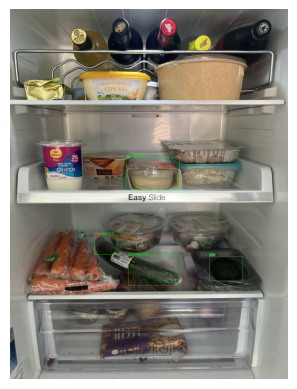

In [42]:
predict_new('/content/my_photos_annotated/images/IMG_3882 2.jpeg')


0: 640x480 1 Cucumber, 3 avocados, 69.8ms
Speed: 0.4ms preprocess, 69.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


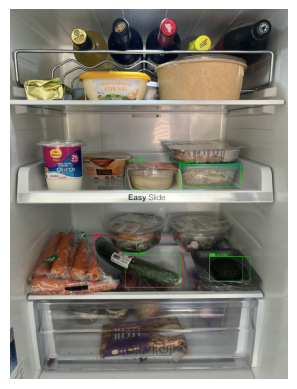

In [44]:
predict_new_finetuned('/content/my_photos_annotated/images/IMG_3882 2.jpeg')

I tried - I can see it does not wrongly classify the tomatoes, it just gets the 3 apples. It is more accurate. Let's see on another example.


0: 640x480 4 Apples, 5 eggs, 2 egg_s, 2 green chillis, 67.3ms
Speed: 0.6ms preprocess, 67.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


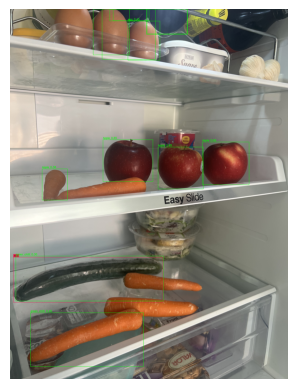

In [45]:
predict_new('/content/my_photos_annotated/images/IMG_3888 2.jpeg')


0: 640x480 3 Apples, 2 egg_s, 63.9ms
Speed: 0.5ms preprocess, 63.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


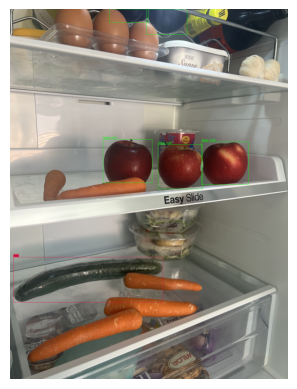

In [46]:
predict_new_finetuned('/content/my_photos_annotated/images/IMG_3888 2.jpeg')

I can see it is marginally doing better - noticing more ingredients if there are more and trying not to wrongly classify.

I have only retrained the model on 27 more images. Imagine if we had much more...

In [47]:
import os
import random
from PIL import Image
from torchvision import transforms

# Define function to perform data augmentation and save augmented images
def augment_images(images_dir, num_augmentations=5):
    # Ensure the directory exists for saving augmented images
    os.makedirs(images_dir, exist_ok=True)

    # Define transformations
    data_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=(-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ])

    # Iterate over each image file and augment
    for image_file in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_file)

        # Load the image
        img = Image.open(image_path)

        # Perform augmentations and save augmented images
        for i in range(num_augmentations):
            transformed_img = data_transforms(img)
            new_image_path = os.path.join(images_dir, f"augmented_{i}_{image_file}")
            transformed_img.save(new_image_path)

# Example usage
images_dir = '/content/my_photos_annotated/images'
augment_images(images_dir, num_augmentations=5)

We have just created aumented images for the purpose of having more training data. Let's look into how many images we have now to train on, and let's retrain.

In [49]:
from ultralytics import YOLO
import zipfile
import yaml

# Step 2: Load your pretrained model
pretrained_model_path = '/content/runs/detect/fine_tuned_model/weights/best.pt'
training_model = YOLO(pretrained_model_path)

## Read in your dataset configuration YAML
dataset_config_file = '/content/datasets/roboflow_dataset/data.yaml'

# Step 4: Configure training parameters and perform transfer learning
training_model.train(
    data=dataset_config_file,
    epochs=2,
    batch=13,
    name='fine_tuned_model',
    lr0=0.001,
    exist_ok=True,
)

New https://pypi.org/project/ultralytics/8.2.65 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU
yolo/engine/trainer: task=detect, mode=train, model=/content/runs/detect/fine_tuned_model/weights/best.pt, data=/content/datasets/roboflow_dataset/data.yaml, epochs=2, patience=50, batch=13, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=fine_tuned_model, exist_ok=True, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=F

In [50]:
training_model = YOLO(f'/content/runs/detect/fine_tuned_model/weights/best.pt')


0: 640x480 2 Cucumbers, 1 avocado, 78.1ms
Speed: 0.5ms preprocess, 78.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


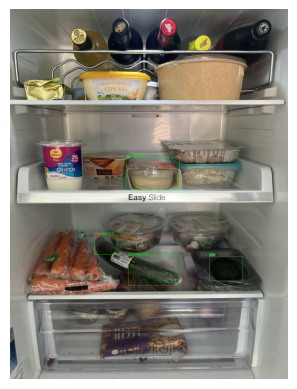

In [51]:
predict_new('/content/my_photos_annotated/images/IMG_3882 2.jpeg')


0: 640x480 1 Cucumber, 57.4ms
Speed: 0.4ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


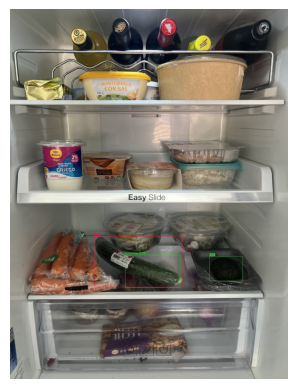

In [52]:
predict_new_finetuned('/content/my_photos_annotated/images/IMG_3882 2.jpeg')


0: 640x480 4 Apples, 5 eggs, 2 egg_s, 2 green chillis, 58.8ms
Speed: 0.8ms preprocess, 58.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


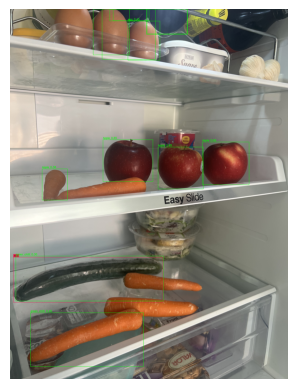

In [53]:
predict_new('/content/my_photos_annotated/images/IMG_3888 2.jpeg')


0: 640x480 3 Apples, 2 egg_s, 71.7ms
Speed: 0.5ms preprocess, 71.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


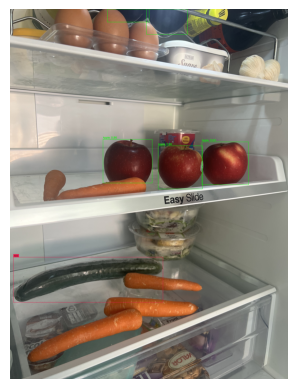

In [54]:
predict_new_finetuned('/content/my_photos_annotated/images/IMG_3888 2.jpeg')

## Plot Comparison
Now im going to compare the recipe with what is showing in the realtime detection or in the upload images.

In [60]:
import torch

# Load the trained YOLOv8 model
model_path = '/content/runs/detect/train2/weights/best.pt'
model = YOLO('/content/yolov8n.pt')

FileUpload(value={}, accept='image/*', description='Upload')

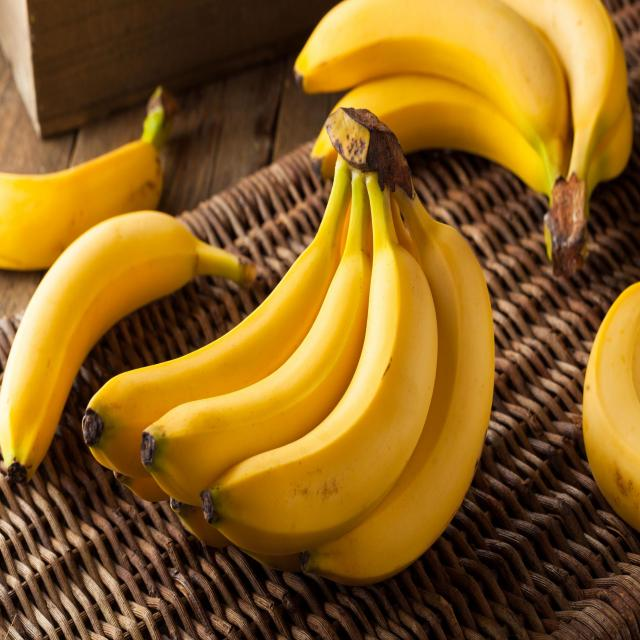


0: 640x640 9 bananas, 76.7ms
Speed: 0.6ms preprocess, 76.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Predicted Ingredients: ['banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana']
Comparison between Model Predictions and Actual Recipe:


Ingredient   Status
0     banana  Correct
1     banana  Correct
2     banana  Correct
3     banana  Correct
4     banana  Correct
5     banana  Correct
6     banana  Correct
7     banana  Correct
8     banana  Correct

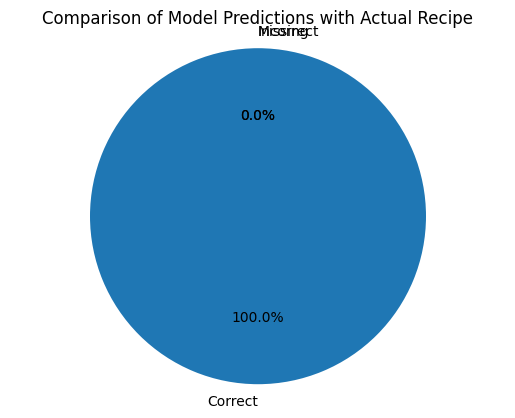

In [66]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained YOLOv8 model
model_path = '/content/runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

# Create an uploader widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

def on_upload_change(change):
    uploaded_file = next(iter(uploader.value.values()))  # Get the first uploaded file
    image_data = uploaded_file['content']
    image = Image.open(io.BytesIO(image_data))
    display(image)

    # Run the model on the uploaded image
    results = model(image)

    # Extract the predicted ingredients (this will depend on your model's output format)
    predictions = [model.names[int(x[-1])] for x in results[0].boxes.data.tolist()]  # Adjust as needed for your model
    print(f"Predicted Ingredients: {predictions}")

    # Define the actual recipe
    actual_recipe = ['banana']  # Replace with actual ingredients

    # Compare predictions with actual recipe
    display_comparison(predictions, actual_recipe)

uploader.observe(on_upload_change, names='value')
display(uploader)

# Function to compare the two lists
def compare_predictions(predictions, actual):
    comparison = []
    for pred in predictions:
        if pred in actual:
            comparison.append((pred, 'Correct'))
        else:
            comparison.append((pred, 'Incorrect'))
    for act in actual:
        if act not in predictions:
            comparison.append((None, 'Missing ' + act))
    return comparison

def display_comparison(predictions, actual):
    comparison_results = compare_predictions(predictions, actual)
    comparison_results_df = pd.DataFrame(comparison_results, columns=['Ingredient', 'Status'])

    print("Comparison between Model Predictions and Actual Recipe:")
    display(comparison_results_df)

    plot_comparison(comparison_results_df)

def plot_comparison(comparison_df):
    correct = comparison_df[comparison_df['Status'] == 'Correct'].shape[0]
    incorrect = comparison_df[comparison_df['Status'] == 'Incorrect'].shape[0]
    missing = comparison_df['Status'].str.contains('Missing').sum()

    labels = ['Correct', 'Incorrect', 'Missing']
    sizes = [correct, incorrect, missing]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Comparison of Model Predictions with Actual Recipe')
    plt.show()

In [67]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [73]:
def send_email_alert(to_email, subject, message):
    from_email = 'focusconsulting.col@gmail.com'  # Replace with your email
    from_password = 'MariaJose2024.'  # Replace with your email password

    # Create the email content
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))

    # Send the email
    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(from_email, from_password)
        text = msg.as_string()
        server.sendmail(from_email, to_email, text)
        server.quit()
        print("Email sent successfully")
    except Exception as e:
        print(f"Failed to send email: {e}")

FileUpload(value={}, accept='image/*', description='Upload')

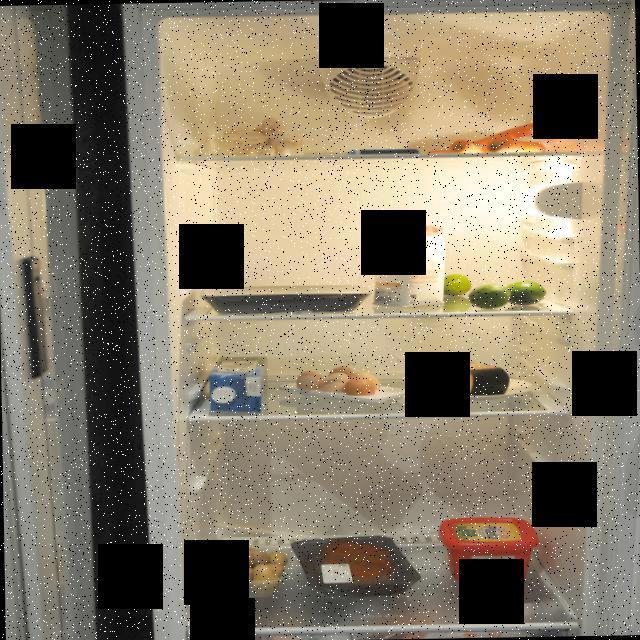


0: 640x640 2 beefs, 1 butter, 1 lime, 2 milks, 2 potatos, 1 sugar, 103.8ms
Speed: 0.7ms preprocess, 103.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Predicted Ingredients: ['beef', 'butter', 'beef', 'sugar', 'potato', 'milk', 'potato', 'lime', 'milk']
Comparison between Model Predictions and Actual Recipe:


Ingredient          Status
0       beef       Incorrect
1     butter       Incorrect
2       beef       Incorrect
3      sugar       Incorrect
4     potato       Incorrect
5       milk       Incorrect
6     potato       Incorrect
7       lime       Incorrect
8       milk       Incorrect
9       None  Missing banana

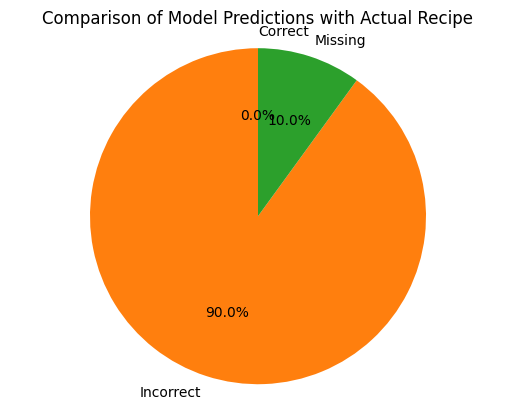

Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-1fed7c7fcefsm17578945ad.60 - gsmtp')


In [74]:
# Load the trained YOLOv8 model
model_path = '/content/runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

# Create an uploader widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

def on_upload_change(change):
    uploaded_file = next(iter(uploader.value.values()))  # Get the first uploaded file
    image_data = uploaded_file['content']
    image = Image.open(io.BytesIO(image_data))
    display(image)

    # Run the model on the uploaded image
    results = model(image)

    # Extract the predicted ingredients (this will depend on your model's output format)
    predictions = [model.names[int(x[-1])] for x in results[0].boxes.data.tolist()]  # Adjust as needed for your model
    print(f"Predicted Ingredients: {predictions}")

    # Define the actual recipe
    actual_recipe = ['banana']  # Replace with actual ingredients

    # Compare predictions with actual recipe and check for alerts
    send_alert = display_comparison(predictions, actual_recipe)

    if send_alert:
        message = 'Incorrect or missing ingredient detected in the uploaded image.'
        send_email_alert('focusconsulting.col@gmail.com', 'Ingredient Alert', message)

uploader.observe(on_upload_change, names='value')
display(uploader)

# Function to compare the two lists
def compare_predictions(predictions, actual):
    comparison = []
    send_alert = False
    for pred in predictions:
        if pred in actual:
            comparison.append((pred, 'Correct'))
        else:
            comparison.append((pred, 'Incorrect'))
            send_alert = True
    for act in actual:
        if act not in predictions:
            comparison.append((None, 'Missing ' + act))
            send_alert = True
    return comparison, send_alert

def display_comparison(predictions, actual):
    comparison_results, send_alert = compare_predictions(predictions, actual)
    comparison_results_df = pd.DataFrame(comparison_results, columns=['Ingredient', 'Status'])

    print("Comparison between Model Predictions and Actual Recipe:")
    display(comparison_results_df)

    plot_comparison(comparison_results_df)

    return send_alert

def plot_comparison(comparison_df):
    correct = comparison_df[comparison_df['Status'] == 'Correct'].shape[0]
    incorrect = comparison_df[comparison_df['Status'] == 'Incorrect'].shape[0]
    missing = comparison_df['Status'].str.contains('Missing').sum()

    labels = ['Correct', 'Incorrect', 'Missing']
    sizes = [correct, incorrect, missing]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Comparison of Model Predictions with Actual Recipe')
    plt.show()

## Email warning
Now that we have the comparison we want to alert someone to help with the correction of the recipe.

Connecting to the SMTP server...
Logging in to the SMTP server...
Sending the email...
Email sent successfully


FileUpload(value={}, accept='image/*', description='Upload')

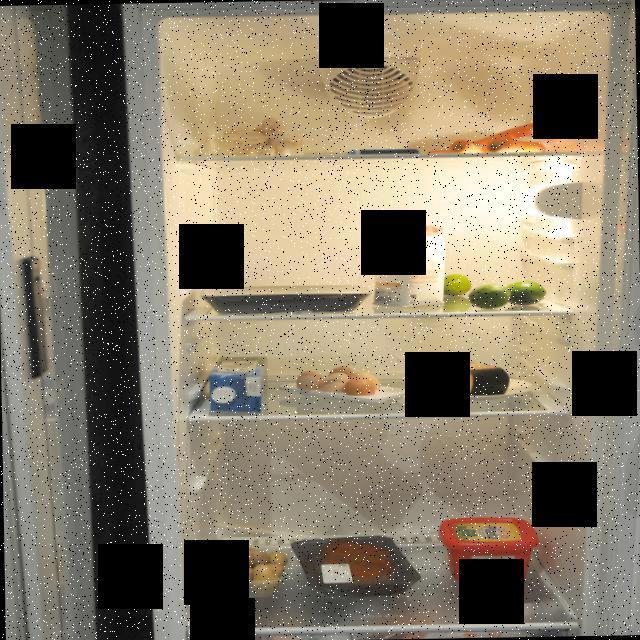


0: 640x640 2 beefs, 1 butter, 1 lime, 2 milks, 2 potatos, 1 sugar, 101.1ms
Speed: 0.6ms preprocess, 101.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Predicted Ingredients: ['beef', 'butter', 'beef', 'sugar', 'potato', 'milk', 'potato', 'lime', 'milk']
Comparison between Model Predictions and Actual Recipe:


Ingredient          Status
0       beef       Incorrect
1     butter       Incorrect
2       beef       Incorrect
3      sugar       Incorrect
4     potato       Incorrect
5       milk       Incorrect
6     potato       Incorrect
7       lime       Incorrect
8       milk       Incorrect
9       None  Missing banana

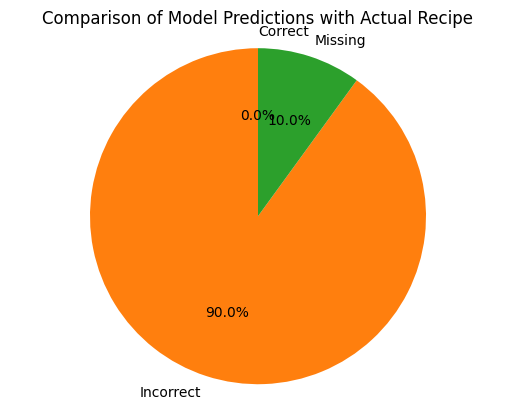

Connecting to the SMTP server...
Logging in to the SMTP server...
Sending the email...
Email sent successfully


In [86]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

def send_email_alert(to_email, subject, message):
    from_email = 'mariaelena.garcia@utp.edu.co'  # Replace with your email
    from_password = 'vjjb odjf ryrw ltyq'  # Replace with your app-specific password

    # Create the email content
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(message, 'plain'))

    # Send the email
    try:
        print("Connecting to the SMTP server...")
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        print("Logging in to the SMTP server...")
        server.login(from_email, from_password)
        print("Sending the email...")
        text = msg.as_string()
        server.sendmail(from_email, to_email, text)
        server.quit()
        print("Email sent successfully")
    except Exception as e:
        print(f"Failed to send email: {e}")

# Test the email function separately
send_email_alert('focusconsulting.col@gmail.com', 'Test Email', 'This is a test email to verify the functionality.')

# Load the trained YOLOv8 model
model_path = '/content/runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

# Create an uploader widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

def on_upload_change(change):
    uploaded_file = next(iter(uploader.value.values()))  # Get the first uploaded file
    image_data = uploaded_file['content']
    image = Image.open(io.BytesIO(image_data))
    display(image)

    # Run the model on the uploaded image
    results = model(image)

    # Extract the predicted ingredients (this will depend on your model's output format)
    predictions = [model.names[int(x[-1])] for x in results[0].boxes.data.tolist()]  # Adjust as needed for your model
    print(f"Predicted Ingredients: {predictions}")

    # Define the actual recipe
    actual_recipe = ['banana']  # Replace with actual ingredients

    # Compare predictions with actual recipe and check for alerts
    send_alert = display_comparison(predictions, actual_recipe)

    if send_alert:
        message = 'Incorrect or missing ingredient detected in the uploaded image.'
        send_email_alert('mariaelena.garcia@utp.edu.co', 'Ingredient Alert', message)

uploader.observe(on_upload_change, names='value')
display(uploader)

# Function to compare the two lists
def compare_predictions(predictions, actual):
    comparison = []
    send_alert = False
    for pred in predictions:
        if pred in actual:
            comparison.append((pred, 'Correct'))
        else:
            comparison.append((pred, 'Incorrect'))
            send_alert = True
    for act in actual:
        if act not in predictions:
            comparison.append((None, 'Missing ' + act))
            send_alert = True
    return comparison, send_alert

def display_comparison(predictions, actual):
    comparison_results, send_alert = compare_predictions(predictions, actual)
    comparison_results_df = pd.DataFrame(comparison_results, columns=['Ingredient', 'Status'])

    print("Comparison between Model Predictions and Actual Recipe:")
    display(comparison_results_df)

    plot_comparison(comparison_results_df)

    return send_alert

def plot_comparison(comparison_df):
    correct = comparison_df[comparison_df['Status'] == 'Correct'].shape[0]
    incorrect = comparison_df[comparison_df['Status'] == 'Incorrect'].shape[0]
    missing = comparison_df['Status'].str.contains('Missing').sum()

    labels = ['Correct', 'Incorrect', 'Missing']
    sizes = [correct, incorrect, missing]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Comparison of Model Predictions with Actual Recipe')
    plt.show()